# Emojify!

Welcome to the second assignment! You're going to use word vector representations to build an Emojifier.
🤩 💫 🔥

Have you ever wanted to make your text messages more expressive? Your emojifier app will help you do that.
Rather than writing:
>"Congratulations on the promotion! Let's get coffee and talk. Love you!"   

The emojifier can automatically turn this into:
>"Congratulations on the promotion! 👍  Let's get coffee and talk. ☕️ Love you! ❤️"

You'll implement a model which inputs a sentence (such as "Let's go see the baseball game tonight!") and finds the most appropriate emoji to be used with this sentence (⚾️).

### Using Word Vectors to Improve Emoji Lookups
* In many emoji interfaces, you need to remember that ❤️  is the "heart" symbol rather than the "love" symbol.
    * In other words, you'll have to remember to type "heart" to find the desired emoji, and typing "love" won't bring up that symbol.
* You can make a more flexible emoji interface by using word vectors!
* When using word vectors, you'll see that even if your training set explicitly relates only a few words to a particular emoji, your algorithm will be able to generalize and associate additional words in the test set to the same emoji.
    * This works even if those additional words don't even appear in the training set.
    * This allows you to build an accurate classifier mapping from sentences to emojis, even using a small training set.

### What you'll build:
1. In this exercise, you'll start with a baseline model (Emojifier-V1) using word embeddings.
2. Then you will build a more sophisticated model (Emojifier-V2) that further incorporates an LSTM.

By the end of this notebook, you'll be able to:

* Create an embedding layer in Keras with pre-trained word vectors
* Explain the advantages and disadvantages of the GloVe algorithm
* Describe how negative sampling learns word vectors more efficiently than other methods
* Build a sentiment classifier using word embeddings
* Build and train a more sophisticated classifier using an LSTM

🏀 👑

👆 😎

(^^^ Emoji for "skills")

## **Download data and GloVE embeddings from Kaggle. For this purpose, you should download kaggle.json file from your Kaggle Account. (Create, if you still don't have one). Go to https://www.kaggle.com/settings/account and click Create New Token. Then, in the next cell upload the json file.**

In [2]:
from google.colab import drive, files
drive.mount('/content/gdrive')

# You should upload the kaggle.json file once the popup appears
files.upload()

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alextrifonov64","key":"65636fa8a5f7468fdc1cb06b22bdb709"}'}

In [3]:
# Verify that the kaggle.json is uploaded
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 May 16 02:54 kaggle.json


In [4]:
#install kaggle package, move the kaggle.json in the appropriate folder and download the datasets.
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation
!unzip glove-global-vectors-for-word-representation.zip
!kaggle datasets download -d mruanova/emojify
!unzip emojify.zip

Dataset URL: https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation
License(s): other
 88% 404M/458M [00:07<00:01, 52.4MB/s]
100% 458M/458M [00:07<00:00, 64.0MB/s]
Archive:  glove-global-vectors-for-word-representation.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.50d.txt        
Dataset URL: https://www.kaggle.com/datasets/mruanova/emojify
License(s): unknown
  0% 0.00/7.98k [00:00<?, ?B/s]
100% 7.98k/7.98k [00:00<00:00, 28.0MB/s]
Archive:  emojify.zip
  inflating: emojify_data.csv        
  inflating: tes.csv                 
  inflating: tess.csv                
  inflating: tesss.csv               
  inflating: test_emoji.csv          
  inflating: testing.csv             
  inflating: train_emoji.csv         


<a name='0'></a>
## Packages

Let's get started! Run the following cell to load the packages you're going to use.

In [5]:
!pip install emoji==1.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171031 sha256=15980a43da7a801a46a0e4882a2d6c42017f0311b5cb52e2e22abcd30c9cc8be
  Stored in directory: /root/.cache/pip/wheels/bd/22/e5/b69726d5e1a19795ecd3b3e7464b16c0f1d019aa94ff1c8578
Successfully built emoji


In [6]:
import csv
import numpy as np
import pandas as pd
import emoji
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

### Helper functions

In [7]:

def read_glove_vecs(glove_file):
    with open(glove_file, 'r',  encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def read_csv(filename = 'data/emojify_data.csv'):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y


emoji_dictionary = {#"0": ":red_heart:",    # :heart: prints a black instead of red heart depending on the font
                    "0": "\u2764\ufe0f",
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)


def print_predictions(X, pred):
    print()
    for i in range(X.shape[0]):
        print(X[i], label_to_emoji(int(pred[i])))


def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):

    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)

    df_conf_norm = df_confusion / df_confusion.sum(axis=1)

    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)



def predict(X, Y, W, b, word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.

    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)

    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    any_word = list(word_to_vec_map.keys())[0]
    # number of classes
    n_h = word_to_vec_map[any_word].shape[0]

    for j in range(m):                       # Loop over training examples

        # Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()

        # Average words' vectors
        avg = np.zeros((n_h,))
        count = 0
        for w in words:
            if w in word_to_vec_map:
                avg += word_to_vec_map[w]
                count += 1

        if count > 0:
            avg = avg / count

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)

    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))

    return pred



<a name='1'></a>
## 1 - Baseline Model: Emojifier-V1

<a name='1-1'></a>
### 1.1 - Dataset EMOJISET

Let's start by building a simple baseline classifier.

You have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings).
- Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence.

<img src="https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C5%20-%20Sequence%20Models/Week%202/Emojify/images/data_set.png?raw=true" style="width:700px;height:300px;">
<caption><center><font color='purple'><b>Figure 1</b>: EMOJISET - a classification problem with 5 classes. A few examples of sentences are given here. </center></caption>

Load the dataset using the code below. The dataset is split between training (127 examples) and testing (56 examples).

In [8]:
X_train, Y_train = read_csv('train_emoji.csv')
X_test, Y_test = read_csv('tesss.csv')

In [9]:
maxLen = len(max(X_train, key=len).split())

Run the following cell to print sentences from X_train and corresponding labels from Y_train.
* Change `idx` to see different examples.
* Note that due to the font used by iPython notebook, the heart emoji may be colored black rather than red.

In [10]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


<ipython-input-7-ac1e9ac051f0>:58: DeprecationWarning: The parameter 'use_aliases' in emoji.emojize() is deprecated and will be removed in version 2.0.0. Use language='alias' instead.
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)


<a name='1-2'></a>
### 1.2 - Overview of the Emojifier-V1

In this section, you'll implement a baseline model called "Emojifier-v1".  

<center>
<img src="https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C5%20-%20Sequence%20Models/Week%202/Emojify/images/image_1.png?raw=true" style="width:900px;height:300px;">
    <caption><center><font color='purple'><b>Figure 2</b>: Baseline model (Emojifier-V1).</center></caption>
</center></font>


#### Inputs and Outputs
* The input of the model is a string corresponding to a sentence (e.g. "I love you").
* The output will be a probability vector of shape (1,5), (indicating that there are 5 emojis to choose from).
* The (1,5) probability vector is passed to an argmax layer, which extracts the index of the emoji with the highest probability.

#### One-hot Encoding
* To get your labels into a format suitable for training a softmax classifier, convert $Y$ from its current shape  $(m, 1)$ into a "one-hot representation" $(m, 5)$,
    * Each row is a one-hot vector giving the label of one example.
    * Here, `Y_oh` stands for "Y-one-hot" in the variable names `Y_oh_train` and `Y_oh_test`:

In [ ]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

Now, see what `convert_to_one_hot()` did. Feel free to change `index` to print out different values.

In [ ]:
idx = 42
print(f"Sentence '{X_train[idx]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I adore my dogs' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


<ipython-input-10-ac1e9ac051f0>:58: DeprecationWarning: The parameter 'use_aliases' in emoji.emojize() is deprecated and will be removed in version 2.0.0. Use language='alias' instead.
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)


All the data is now ready to be fed into the Emojify-V1 model. You're ready to implement the model!

<a name='1-3'></a>
### 1.3 - Implementing Emojifier-V1

As shown in Figure 2 (above), the first step is to:
* Convert each word in the input sentence into their word vector representations.
* Take an average of the word vectors.

Similar to this week's previous assignment, you'll use pre-trained 50-dimensional GloVe embeddings.

Run the following cell to load the `word_to_vec_map`, which contains all the vector representations.

In [11]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

You've loaded:
- `word_to_index`: dictionary mapping from words to their indices in the vocabulary
    - (400,001 words, with the valid indices ranging from 0 to 400,000)
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation. (50-dimensional)

Run the following cell to check if it works:

In [ ]:
word = "cucumber"
idx = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


<a name='ex-1'></a>
### Exercise 1 - sentence_to_avg

Implement `sentence_to_avg()`

You'll need to carry out two steps:

1. Convert every sentence to lower-case, then split the sentence into a list of words.
    * `X.lower()` and `X.split()` might be useful. 😉
2. For each word in the sentence, access its GloVe representation.
    * Then take the average of all of these word vectors.
    * You might use `numpy.zeros()`, which you can read more about [here]('https://numpy.org/doc/stable/reference/generated/numpy.zeros.html').
    
    
#### Additional Hints
* When creating the `avg` array of zeros, you'll want it to be a vector of the same shape as the other word vectors in the `word_to_vec_map`.  
    * You can choose a word that exists in the `word_to_vec_map` and access its `.shape` field.
    * Be careful not to hard-code the word that you access.  In other words, don't assume that if you see the word 'the' in the `word_to_vec_map` within this notebook, that this word will be in the `word_to_vec_map` when the function is being called by the automatic grader.

**Hint**: you can use any one of the word vectors that you retrieved from the input `sentence` to find the shape of a word vector.

In [ ]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: sentence_to_avg

def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.

    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation

    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    # Get a valid word contained in the word_to_vec_map.
    any_word = list(word_to_vec_map.keys())[0]
    ### START CODE HERE ###
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = sentence.lower().split()
    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(word_to_vec_map[any_word].shape)
    # Initialize count to 0
    count = 0
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    for word in words:
      if word in word_to_vec_map:
        avg += word_to_vec_map[word]
        count += 1

    if count > 0:
      avg = avg / count
    ### END CODE HERE ###

    return avg

In [ ]:
# BEGIN UNIT TEST
avg = sentence_to_avg("Morrocan couscous is my favorite dish", word_to_vec_map)
print("avg = \n", avg)

def sentence_to_avg_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2],
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0],
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])

    avg = target("a a_nw c_w a_s", word_to_vec_map)
    assert tuple(avg.shape) == tuple(word_to_vec_map['a'].shape),  "Check the shape of your avg array"
    assert np.allclose(avg, [1.25, 2.5]),  "Check that you are finding the 4 words"
    avg = target("love a a_nw c_w a_s", word_to_vec_map)
    assert np.allclose(avg, [1.25, 2.5]), "Divide by count, not len(words)"
    avg = target("love", word_to_vec_map)
    assert np.allclose(avg, [0, 0]), "Average of no words must give an array of zeros"
    avg = target("c_se foo a a_nw c_w a_s deeplearning c_nw", word_to_vec_map)
    assert np.allclose(avg, [0.1666667, 2.0]), "Debug the last example"

    print("\033[92mAll tests passed!")

sentence_to_avg_test(sentence_to_avg)

# END UNIT TEST

avg = 
 [-0.008005    0.56370833 -0.50427333  0.258865    0.55131103  0.03104983
 -0.21013718  0.16893933 -0.09590267  0.141784   -0.15708967  0.18525867
  0.6495785   0.38371117  0.21102167  0.11301667  0.02613967  0.26037767
  0.05820667 -0.01578167 -0.12078833 -0.02471267  0.4128455   0.5152061
  0.38756167 -0.898661   -0.535145    0.33501167  0.68806933 -0.2156265
  1.797155    0.10476933 -0.36775333  0.750785    0.10282583  0.348925
 -0.27262833  0.66768    -0.10706167 -0.283635    0.59580117  0.28747333
 -0.3366635   0.23393817  0.34349183  0.178405    0.1166155  -0.076433
  0.1445417   0.09808667]
All tests passed!


<a name='1-4'></a>
### 1.4 - Implement the Model

You now have all the pieces to finish implementing the `model()` function!
After using `sentence_to_avg()` you need to:
* Pass the average through forward propagation
* Compute the cost
* Backpropagate to update the softmax parameters

<a name='ex-2'></a>
### Exercise 2 - model

Implement the `model()` function described in Figure (2).

* The equations you need to implement in the forward pass and to compute the cross-entropy cost are below:
* The variable $Y_{oh}$ ("Y one hot") is the one-hot encoding of the output labels.

$$ z^{(i)} = W . avg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$

**Note**: It is possible to come up with a more efficient vectorized implementation. For now, just use nested for loops to better understand the algorithm, and for easier debugging.

The function `softmax()` is provided, and has already been imported.

In [ ]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: model

def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 200):
    """
    Model to train word vector representations in numpy.

    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations

    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """

    # Get a valid word contained in the word_to_vec_map
    any_word = list(word_to_vec_map.keys())[0]

    # Initialize cost. It is needed during grading
    cost = 0

    # Define number of training examples
    m = Y.shape[0]                             # number of training examples
    n_y = len(np.unique(Y))                    # number of classes
    n_h = word_to_vec_map[any_word].shape[0]   # dimensions of the GloVe vectors

    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))

    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y)

    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples

            ### START CODE HERE ### (≈ 4 lines of code)
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = W @ avg + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -np.sum(Y_oh[i] * np.log(a))
            ### END CODE HERE ###

            # Compute gradients
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db

        if t % 10 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emo_utils.py

    return pred, W, b

In [ ]:
# UNIT TEST
def model_test(target):
    # Create a controlled word to vec map
    word_to_vec_map = {'a': [3, 3], 'synonym_of_a': [3, 3], 'a_nw': [2, 4], 'a_s': [3, 2], 'a_n': [3, 4],
                       'c': [-2, 1], 'c_n': [-2, 2],'c_ne': [-1, 2], 'c_e': [-1, 1], 'c_se': [-1, 0],
                       'c_s': [-2, 0], 'c_sw': [-3, 0], 'c_w': [-3, 1], 'c_nw': [-3, 2]
                      }
    # Convert lists to np.arrays
    for key in word_to_vec_map.keys():
        word_to_vec_map[key] = np.array(word_to_vec_map[key])

    # Training set. Sentences composed of a_* words will be of class 0 and sentences composed of c_* words will be of class 1
    X = np.asarray(['a a_s synonym_of_a a_n c_sw', 'a a_s a_n c_sw', 'a_s  a a_n', 'synonym_of_a a a_s a_n c_sw', " a_s a_n",
                    " a a_s a_n c ", " a_n  a c c c_e",
                   'c c_nw c_n c c_ne', 'c_e c c_se c_s', 'c_nw c a_s c_e c_e', 'c_e a_nw c_sw', 'c_sw c c_ne c_ne'])

    Y = np.asarray([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

    np.random.seed(10)
    pred, W, b = model(X, Y, word_to_vec_map, 0.0025, 110)

    assert W.shape == (2, 2), "W must be of shape 2 x 2"
    assert np.allclose(pred.transpose(), Y), "Model must give a perfect accuracy"
    assert np.allclose(b[0], -1 * b[1]), "b should be symmetric in this example"

    print("\033[92mAll tests passed!")

model_test(model)

Epoch: 0 --- cost = 0.05105772513207822
Accuracy: 0.9166666666666666
Epoch: 10 --- cost = 0.03893716809550303
Accuracy: 0.9166666666666666
Epoch: 20 --- cost = 0.03078199487865477
Accuracy: 0.9166666666666666
Epoch: 30 --- cost = 0.0250625254818359
Accuracy: 0.9166666666666666
Epoch: 40 --- cost = 0.020906296817970453
Accuracy: 0.9166666666666666
Epoch: 50 --- cost = 0.017791876552201644
Accuracy: 0.9166666666666666
Epoch: 60 --- cost = 0.015394747683241103
Accuracy: 0.9166666666666666
Epoch: 70 --- cost = 0.01350575460904451
Accuracy: 1.0
Epoch: 80 --- cost = 0.01198593465621373
Accuracy: 1.0
Epoch: 90 --- cost = 0.01074046826626526
Accuracy: 1.0
Epoch: 100 --- cost = 0.00970311068897676
Accuracy: 1.0
All tests passed!


In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))
Y = np.asarray([5, 0, 0, 5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and have drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is surprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

print(X.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(type(X_train))


(132,)
(132,)
(132, 5)
never talk to me again
<class 'numpy.ndarray'>
(20,)
(20,)
(132, 5)
<class 'numpy.ndarray'>


Run the next cell to train your model and learn the softmax parameters (W, b). **The training process will take about 5 minutes**

In [ ]:
np.random.seed(1)
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.952049881281007
Accuracy: 0.3484848484848485
Epoch: 10 --- cost = 1.0040987758894053
Accuracy: 0.7272727272727273
Epoch: 20 --- cost = 0.5388772571119417
Accuracy: 0.803030303030303
Epoch: 30 --- cost = 0.3331218997365076
Accuracy: 0.803030303030303
Epoch: 40 --- cost = 0.2314476628942315
Accuracy: 0.8257575757575758
Epoch: 50 --- cost = 0.1747265584802322
Accuracy: 0.8560606060606061
Epoch: 60 --- cost = 0.13985752584011937
Accuracy: 0.8787878787878788
Epoch: 70 --- cost = 0.11677061223976795
Accuracy: 0.8939393939393939
Epoch: 80 --- cost = 0.10058743375666801
Accuracy: 0.9090909090909091
Epoch: 90 --- cost = 0.08872634092095644
Accuracy: 0.9242424242424242
Epoch: 100 --- cost = 0.07971818726014807
Accuracy: 0.9318181818181818
Epoch: 110 --- cost = 0.07267535951826085
Accuracy: 0.9318181818181818
Epoch: 120 --- cost = 0.0670345060004128
Accuracy: 0.9318181818181818
Epoch: 130 --- cost = 0.06242326850488143
Accuracy: 0.9318181818181818
Epoch: 140 --- cost = 0.058

Great! Your model has pretty high accuracy on the training set. Now see how it does on the test set:

<a name='1-5'></a>
### 1.5 - Examining Test Set Performance

Note that the `predict` function used here is defined in `emo_util.spy`.

In [ ]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9545454545454546
Test set:
Accuracy: 0.8571428571428571


In [ ]:
def predict_single(sentence, W=W, b=b, word_to_vec_map=word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.

    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)

    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """

    any_word = list(word_to_vec_map.keys())[0]
    # number of classes
    n_h = word_to_vec_map[any_word].shape[0]

    # Split jth test example (sentence) into list of lower case words
    words = sentence.lower().split()

    # Average words' vectors
    avg = np.zeros((n_h,))
    count = 0
    for w in words:
        if w in word_to_vec_map:
            avg += word_to_vec_map[w]
            count += 1

    if count > 0:
        avg = avg / count

    # Forward propagation
    Z = np.dot(W, avg) + b
    A = softmax(Z)
    pred = np.argmax(A)


    return pred

In [ ]:
label_to_emoji(int(predict_single("I love you")))

<ipython-input-10-ac1e9ac051f0>:58: DeprecationWarning: The parameter 'use_aliases' in emoji.emojize() is deprecated and will be removed in version 2.0.0. Use language='alias' instead.
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)


'❤️'

**Note**:
* Random guessing would have had 20% accuracy, given that there are 5 classes. (1/5 = 20%).
* This is pretty good performance after training on only 127 examples.


#### The Model Matches Emojis to Relevant Words
In the training set, the algorithm saw the sentence
>"I love you."

with the label ❤️.
* You can check that the word "adore" does not appear in the training set.
* Nonetheless, let's see what happens if you write "I adore you."

In [ ]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy", "i am ready", "are you ready"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3], [2], [2]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.625

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄
i am ready 😞
are you ready 🍴


<ipython-input-10-ac1e9ac051f0>:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(X[i], label_to_emoji(int(pred[i])))
<ipython-input-10-ac1e9ac051f0>:58: DeprecationWarning: The parameter 'use_aliases' in emoji.emojize() is deprecated and will be removed in version 2.0.0. Use language='alias' instead.
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)


Amazing!
* Because *adore* has a similar embedding as *love*, the algorithm has generalized correctly even to a word it has never seen before.
* Words such as *heart*, *dear*, *beloved* or *adore* have embedding vectors similar to *love*.
    * Feel free to modify the inputs above and try out a variety of input sentences.
    * How well does it work?

#### Word Ordering isn't Considered in this Model
* Note that the model doesn't get the following sentence correct:
>"not feeling happy"

* This algorithm ignores word ordering, so is not good at understanding phrases like "not happy."

#### Confusion Matrix
* Printing the confusion matrix can also help understand which classes are more difficult for your model.
* A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class).

Print the confusion matrix below:

(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


<ipython-input-10-ac1e9ac051f0>:58: DeprecationWarning: The parameter 'use_aliases' in emoji.emojize() is deprecated and will be removed in version 2.0.0. Use language='alias' instead.
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)


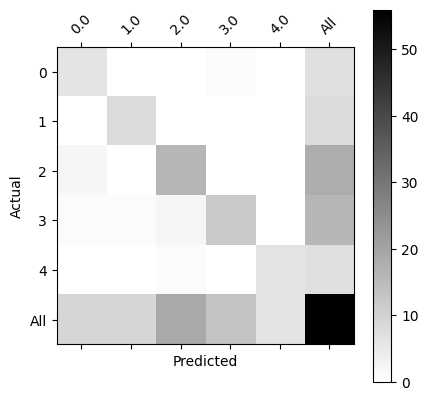

In [ ]:
# START SKIP FOR GRADING
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)
# END SKIP FOR GRADING

<font color='blue'><b>What you should remember:</b>
- Even with a mere 127 training examples, you can get a reasonably good model for Emojifying.
    - This is due to the generalization power word vectors gives you.
- Emojify-V1 will perform poorly on sentences such as *"This movie is not good and not enjoyable"*
    - It doesn't understand combinations of words.
    - It just averages all the words' embedding vectors together, without considering the ordering of words.
</font>
    

## 2 - Emojifier-V2
### Tasks

1. Build an Emojifier using a RNN model
2. What type of RNN did you use Smple RNN, GRU ... why did you choose the specific type
3. Did you use a bidirectional and why


# Answers

Since the sentences from the dataset aren't that long GRU will perform just as well and train faster (due to it's simpler structure) in comparison to LSTM. I've tested both on the current dataset they perform similarly.

A bidirectional RNN is preferred since the meaning of a sentence can be influenced by words after the current observed word.

Capturing information from both direction can lead to improved performance on tasks where word order and context from both sides are important for determining the meaning or sentiment, such as the current task.

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [55]:
def plot_performance(train_losses, train_accuracies, test_losses, test_accuracies):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

  ax1.plot(train_losses, label='Train Loss')
  ax1.plot(test_losses, label='Test Loss')
  ax1.set_title('Loss over Epochs')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()

  ax2.plot(train_accuracies, label='Train Accuracy')
  ax2.plot(test_accuracies, label='Test Accuracy')
  ax2.set_title('Accuracy over Epochs')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  plt.tight_layout()
  plt.show()

In [13]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    vocab_len = len(word_to_index) + 1 # + 1 for special padding token

    embedding_dim = [v.shape[0] for v in word_to_vec_map.values()][0]

    embedding_matrix = np.zeros((vocab_len, embedding_dim))

    for word, index in word_to_index.items():
         if word in word_to_vec_map:
            embedding_matrix[index, :] = word_to_vec_map[word]

    return embedding_matrix

In [14]:
def sentences_to_indices(X, word_to_index, max_len):
  m = X.shape[0]
  X_ids = np.zeros((m, max_len))
  for i in range(m):
    sentence_words = X[i].lower().split()
    j = 0
    for word in sentence_words:
      X_ids[i, j] = word_to_index[word]
      j = j + 1
  return X_ids

In [15]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [16]:
X_train, Y_train = read_csv('train_emoji.csv')
X_test, Y_test = read_csv('tesss.csv')

Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [24]:
maxLen = len(max(X_train, key=len).split())

In [47]:
class Emojifier_V2(nn.Module):
  def __init__(self, embedding_matrix):
    super(Emojifier_V2, self).__init__()

    vocab_size = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]

    self.word_embeds = nn.Embedding(vocab_size, embedding_dim)

    with torch.no_grad():
        self.word_embeds.weight.copy_(torch.from_numpy(embedding_matrix))

    self.rnn = nn.GRU(embedding_dim, 128, 2,batch_first=True,dropout=0.5, bidirectional=True)
    self.linear = nn.Linear(128 * 2,5)
    self.out = nn.Softmax(dim=1)

  def forward(self,x,h):
      out = self.word_embeds(x)
      out, _ = self.rnn(out,h)
      out = out[:, -1, :]
      out = self.linear(out)
      out = self.out(out)
      return out


In [88]:
def get_dataloaders(embedding_matrix, batch_size, max_len):
  X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
  X_test_indices = sentences_to_indices(X_test, word_to_index, max_len)

  X_train_tensor = torch.from_numpy(X_train_indices).long()
  Y_train_tensor = torch.from_numpy(Y_train).long()

  X_test_tensor = torch.from_numpy(X_test_indices).long()
  Y_test_tensor = torch.from_numpy(Y_test).long()

  train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_dataloader, test_dataloader


In [91]:

def train_emojifier_v2(model, train_dataloader, test_dataloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            h0 = torch.zeros(2 * 2, inputs.size(0), 128).to(device)

            optimizer.zero_grad()

            outputs = model(inputs, h0)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / (i + 1)
        epoch_train_accuracy = correct_predictions / total_predictions

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        with torch.no_grad():
            model.eval()
            test_running_loss = 0.0
            test_correct_predictions = 0
            test_total_predictions = 0

            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                h0 = torch.zeros(2 * 2, inputs.size(0), 128).to(device)

                outputs = model(inputs, h0)

                loss = criterion(outputs, labels)

                test_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                test_total_predictions += labels.size(0)
                test_correct_predictions += (predicted == labels).sum().item()

            epoch_test_loss = test_running_loss / len(test_dataloader)
            epoch_test_accuracy = test_correct_predictions / test_total_predictions

            test_losses.append(epoch_test_loss)
            test_accuracies.append(epoch_test_accuracy)


        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")
        print(f"  Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.4f}")

    return train_losses, train_accuracies, test_losses, test_accuracies

In [92]:
batch_size = 32
learning_rate = 0.001

In [93]:

embedding_matrix = pretrained_embedding_layer(word_to_vec_map, word_to_index)

model_v2 = Emojifier_V2(embedding_matrix)

train_dataloader, test_dataloader = get_dataloaders(embedding_matrix, batch_size, maxLen)

embedding_dim = embedding_matrix.shape[1]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v2.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v2.to(device)
print(f"Using device: {device}")

train_losses_v2, train_accuracies_v2, test_losses_v2, test_accuracies_v2 = train_emojifier_v2(
    model_v2,
    train_dataloader,
    test_dataloader,
    criterion,
    optimizer,
    device,
    num_epochs=100
)

Using device: cuda
Epoch 1/100
  Train Loss: 1.5994, Train Accuracy: 0.2803
  Test Loss: 1.5861, Test Accuracy: 0.3214
Epoch 2/100
  Train Loss: 1.5848, Train Accuracy: 0.2879
  Test Loss: 1.5616, Test Accuracy: 0.3214
Epoch 3/100
  Train Loss: 1.5941, Train Accuracy: 0.2879
  Test Loss: 1.5454, Test Accuracy: 0.3214
Epoch 4/100
  Train Loss: 1.5630, Train Accuracy: 0.2576
  Test Loss: 1.5510, Test Accuracy: 0.2857
Epoch 5/100
  Train Loss: 1.5740, Train Accuracy: 0.2727
  Test Loss: 1.5438, Test Accuracy: 0.2857
Epoch 6/100
  Train Loss: 1.5345, Train Accuracy: 0.2727
  Test Loss: 1.5278, Test Accuracy: 0.3750
Epoch 7/100
  Train Loss: 1.4971, Train Accuracy: 0.4394
  Test Loss: 1.4998, Test Accuracy: 0.4643
Epoch 8/100
  Train Loss: 1.4635, Train Accuracy: 0.4848
  Test Loss: 1.4513, Test Accuracy: 0.4643
Epoch 9/100
  Train Loss: 1.4002, Train Accuracy: 0.5303
  Test Loss: 1.4072, Test Accuracy: 0.5179
Epoch 10/100
  Train Loss: 1.3641, Train Accuracy: 0.5152
  Test Loss: 1.3930, Te

# Plotting

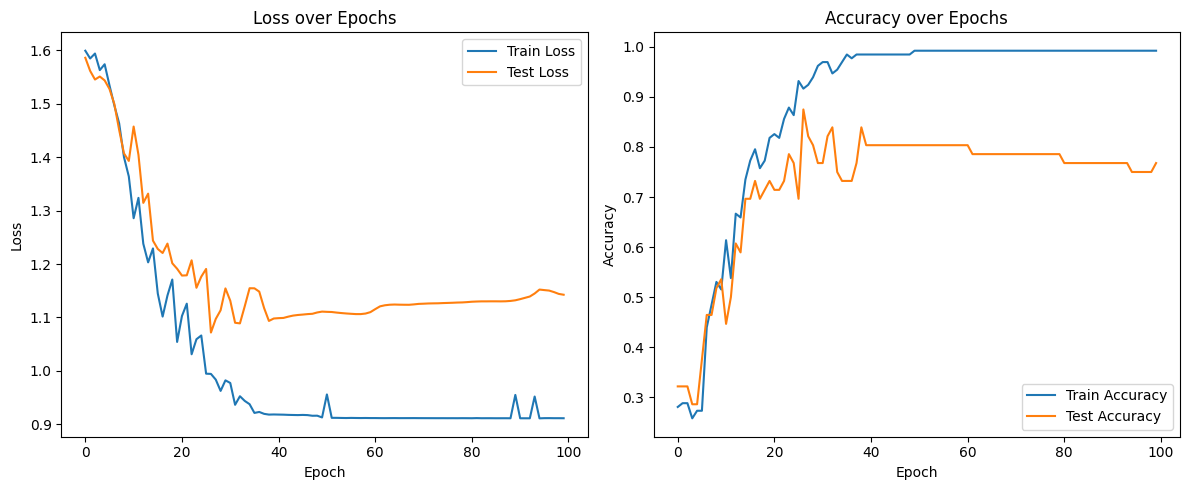

In [94]:
plot_performance(train_losses_v2, train_accuracies_v2, test_losses_v2, test_accuracies_v2)

## 3 - Emojifier-V3
### Tasks

1. Build an Emojifier using a Transformer based model
2. What type of Transformer based did you use Full transformer, Decoder only ... why did you choose the specific type
3. Can the problem be solved with an Full transformer only model and how?
4. Can the problem be solved with an Decoder only model and how?
5. Can the problem be solved with an Encoder only model and how?


# Answers

2. The current problem is text classification. Encoder-only models are well-suited for tasks where you need to understand the context and representation of a given input sequence to perform a classification or analysis on that sequence.

3. It can be solved using a Full transformer but would be inefficient due to the fact that we will use only the encoder portion.

4. We can also solve the problem using decoder only by processing the final hidden state of the decoder using a linear layer in order to classify.

5. Since the solution bellow use Encoder-only transformer, I will outline the steps.



      1. Input sentence is passed through an embedding layer
      2. The embedded sequence is processed by multiple encoder layers
      3. After which we do average pooling (summarizing the sentence's representation)
      4. Final classification layer



In [96]:
class Emojifier_V3(nn.Module):
    def __init__(self, embedding_matrix, max_len, num_heads=2, num_layers=2, dim_feedforward=128):
        super(Emojifier_V3, self).__init__()

        vocab_size = embedding_matrix.shape[0]
        embedding_dim = embedding_matrix.shape[1]
        self.max_len = max_len

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        with torch.no_grad():
            self.word_embeds.weight.copy_(torch.from_numpy(embedding_matrix))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.linear = nn.Linear(embedding_dim, 5)
        self.out = nn.Softmax(dim=1)

    def forward(self, x, mask=None):
        embedded = self.word_embeds(x)

        embedded = embedded.permute(1, 0, 2) # Transformer expects (sequence_length, batch_size, feature_dim)

        transformer_output = self.transformer_encoder(embedded, src_key_padding_mask=mask)

        transformer_output = transformer_output.permute(1, 2, 0) # (batch, features, sequence) for AdaptiveAvgPool1d

        pooled_output = self.pool(transformer_output).squeeze(2) #(batch_size, embedding_dim, 1)

        logits = self.linear(pooled_output)
        output_probs = self.out(logits)

        return output_probs

In [95]:
def train_emojifier_v3(model, train_dataloader, test_dataloader, criterion, optimizer, device, num_epochs, padding_idx=0):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0


        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            padding_mask = (inputs == padding_idx).to(device)

            optimizer.zero_grad()

            outputs = model(inputs, mask=padding_mask)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / (i + 1)
        epoch_train_accuracy = correct_predictions / total_predictions

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)


        with torch.no_grad():
            model.eval()
            test_running_loss = 0.0
            test_correct_predictions = 0
            test_total_predictions = 0

            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                padding_mask = (inputs == padding_idx).to(device)

                outputs = model(inputs, mask=padding_mask)

                loss = criterion(outputs, labels)

                test_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                test_total_predictions += labels.size(0)
                test_correct_predictions += (predicted == labels).sum().item()

            epoch_test_loss = test_running_loss / len(test_dataloader)
            epoch_test_accuracy = test_correct_predictions / test_total_predictions

            test_losses.append(epoch_test_loss)
            test_accuracies.append(epoch_test_accuracy)


        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")
        print(f"  Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.4f}")

    return train_losses, train_accuracies, test_losses, test_accuracies

In [85]:
embedding_matrix = pretrained_embedding_layer(word_to_vec_map, word_to_index)

model_v3 = Emojifier_V3(embedding_matrix, maxLen)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v3.to(device)
print(f"Using device: {device}")

train_dataloader, test_dataloader = get_dataloaders(embedding_matrix, batch_size, maxLen)

criterion = nn.CrossEntropyLoss()
optimizer_v3 = optim.Adam(model_v3.parameters(), lr=learning_rate)

train_losses_v3, train_accuracies_v3, test_losses_v3, test_accuracies_v3 = train_emojifier_v3(
    model_v3,
    train_dataloader,
    test_dataloader,
    criterion,
    optimizer_v3,
    device,
    num_epochs=100
)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Using device: cuda
Epoch 1/100
  Train Loss: 1.5906, Train Accuracy: 0.2197
  Test Loss: 1.5662, Test Accuracy: 0.3214
Epoch 2/100
  Train Loss: 1.5587, Train Accuracy: 0.3106
  Test Loss: 1.5422, Test Accuracy: 0.3571
Epoch 3/100
  Train Loss: 1.5444, Train Accuracy: 0.3636
  Test Loss: 1.5260, Test Accuracy: 0.3750
Epoch 4/100
  Train Loss: 1.5286, Train Accuracy: 0.3788
  Test Loss: 1.5010, Test Accuracy: 0.4107
Epoch 5/100
  Train Loss: 1.4733, Train Accuracy: 0.4318
  Test Loss: 1.4772, Test Accuracy: 0.4643
Epoch 6/100
  Train Loss: 1.4413, Train Accuracy: 0.5530
  Test Loss: 1.4521, Test Accuracy: 0.5179
Epoch 7/100
  Train Loss: 1.4091, Train Accuracy: 0.6061
  Test Loss: 1.4363, Test Accuracy: 0.5179
Epoch 8/100
  Train Loss: 1.3492, Train Accuracy: 0.5985
  Test Loss: 1.3969, Test Accuracy: 0.6250
Epoch 9/100
  Train Loss: 1.3101, Train Accuracy: 0.6515
  Test Loss: 1.3487, Test Accuracy: 0.5714
Epoch 10/100
  Train Loss: 1.2354, Train Accuracy: 0.6742
  Test Loss: 1.3212, Te

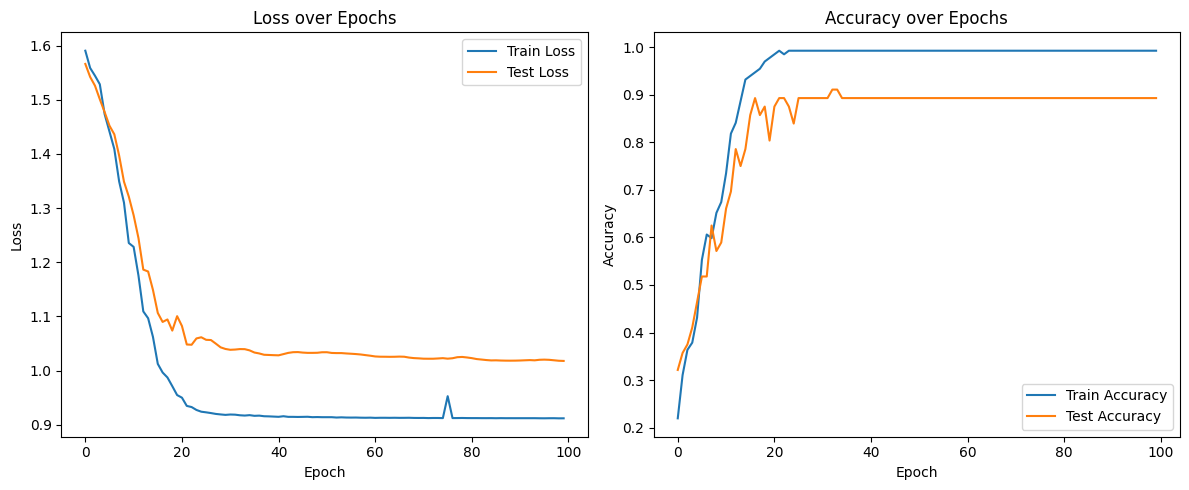

In [87]:
plot_performance(train_losses_v3, train_accuracies_v3, test_losses_v3, test_accuracies_v3)